# Import Libraries

In [1]:
!pip install mne

In [2]:
pip install --upgrade torcheeg

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torcheeg
print(torcheeg.__version__)


1.1.2


In [4]:
import os
import shutil

import mne
mne.set_log_level('error')
from torcheeg.datasets import CSVFolderDataset, before_trial_normalize
from torcheeg import transforms



ImportError: cannot import name 'before_trial_normalize' from 'torcheeg.datasets' (/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/torcheeg/datasets/__init__.py)

In [5]:
# Set the Matplotlib logger to suppress debug messages
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Read data

## Single File

```
ch_names = [
    'Fp1',
    'Fp2',
    'C3',
    'C4',
    'T5',
    'T6',
    'O1',
    'O2',
    'F7',
    'F8',
    'F3',
    'F4',
    'T3',
    'T4',
    'P3',
    'P4'
]
channel_renaming_dict = {f"EEG {idx+1}": name for idx, name in enumerate(ch_names)}
```

### Define constants

In [6]:
root_path = 'eeg_data/openbci'
file_name = 'OpenBCI-BDF-2023-09-05_18-30-02.bdf'
channel_renaming_dict = {
    # 'EEG 1': 'Fp1',
    'EEG 1': 'hEOG',
    'EEG 2': 'Fp2',
    'EEG 3': 'C3',
    'EEG 4': 'C4',
    'EEG 5': 'P7',
    'EEG 6': 'P8',
    'EEG 7': 'O1',
    'EEG 8': 'O2',
    'EEG 9': 'F7',
    'EEG 10': 'F8',
    'EEG 11': 'F3',
    'EEG 12': 'F4',
    'EEG 13': 'T7',
    'EEG 14': 'T8',
    'EEG 15': 'P3',
    'EEG 16': 'P4'
 }

### Read the file, set channel name and positions
- About montage: https://mne.discourse.group/t/montage-for-16-channels-openbci/2652/4
- Montage is a common word used to describe the arrangement of EEG electrodes on a head, or in an EEG cap. In more general usage, montage means “a collection of elements”.

In [7]:
# Read single bdf file
raw = mne.io.read_raw_bdf(
    input_fname=os.path.join(root_path, file_name),
    eog=['EEG 1'],
    misc=['Accel X', 'Accel Y', 'Accel Z'],
    preload=True,
    )

# Change channel name accordingly
raw.rename_channels(channel_renaming_dict)

# Set channel positions
raw.set_montage('standard_1020')
raw

<RawEDF | OpenBCI-BDF-2023-09-05_18-30-02.bdf, 19 x 36500 (292.0 s), ~5.3 MB, data loaded>

In [8]:
# channel list
# raw.info['ch_names']

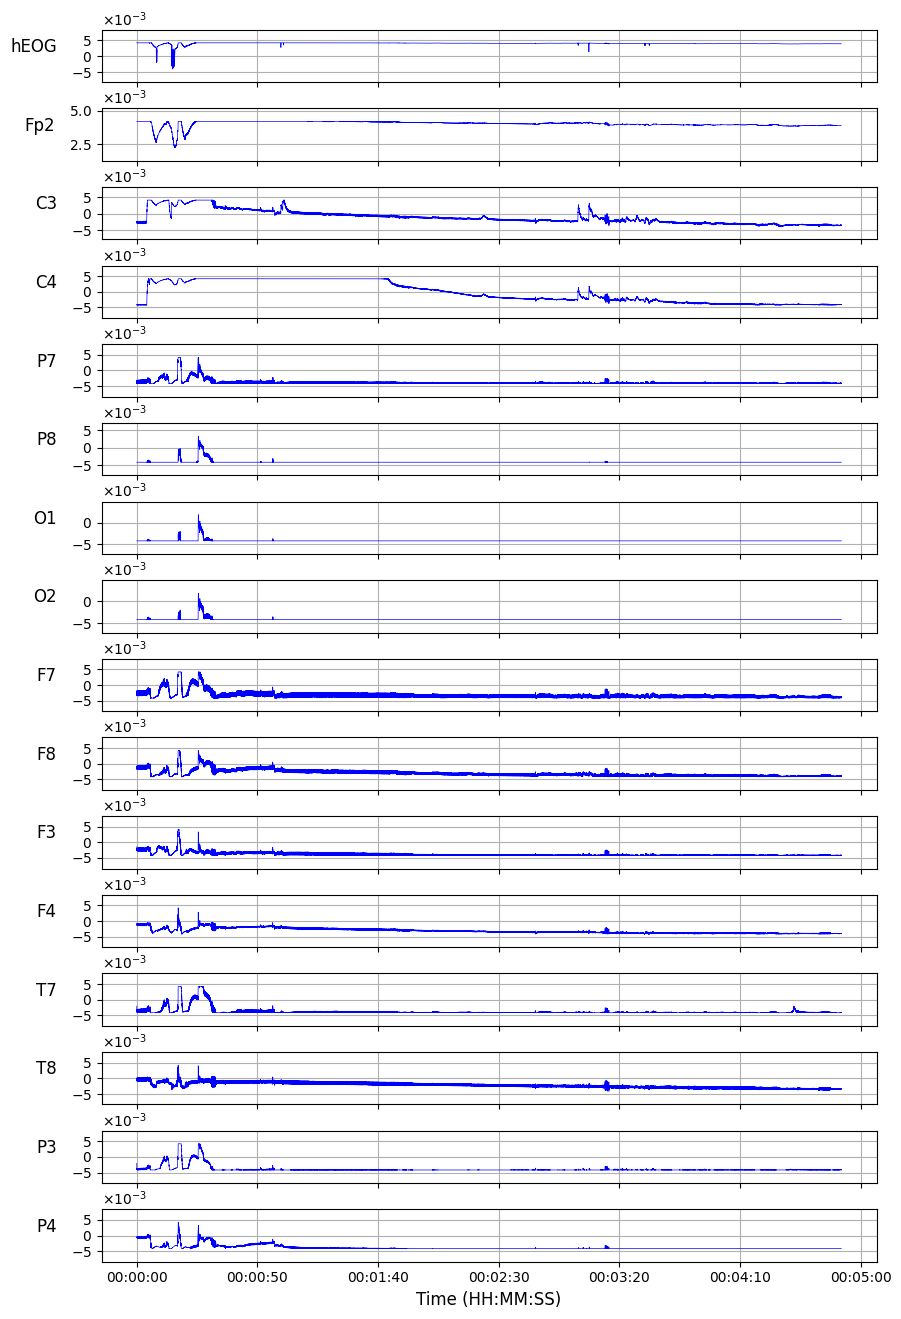

In [9]:
from utils import plot_selected_channels

channels = raw.info['ch_names']
exclude_channels = ['Accel X', 'Accel Y', 'Accel Z']
picks = [ch for ch in channels if ch not in exclude_channels]

plot_selected_channels(
    data=raw._data,
    channel_names=channels,
    selected_channels=picks,
    sampling_rate=125,
    y_padding_percent=0.5
)

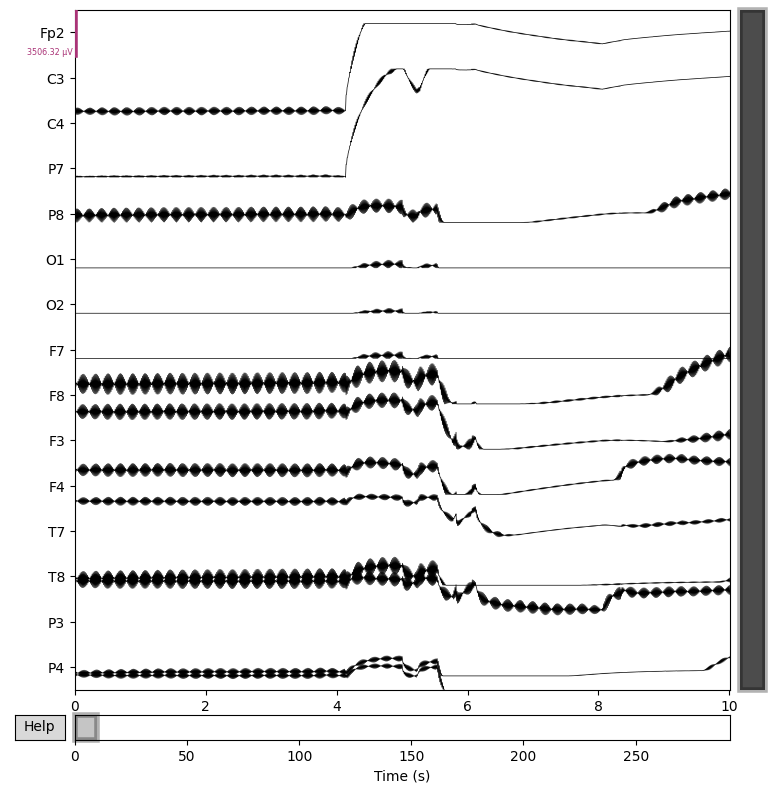

In [10]:
# from MNE, but not clear
eeg_channels = mne.pick_types(raw.info, eeg=True)
raw.plot(order=eeg_channels, scalings='auto', show=True, block=True, remove_dc=False);

In [11]:
# event codes / marker / trigger
mne.events_from_annotations(raw)

(array([], shape=(0, 3), dtype=int64), {})

/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/tmp/ipykernel_3399919/151407237.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(top=0.9)
/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/tmp/ipykernel_3399919/151407237.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(top=0.9)


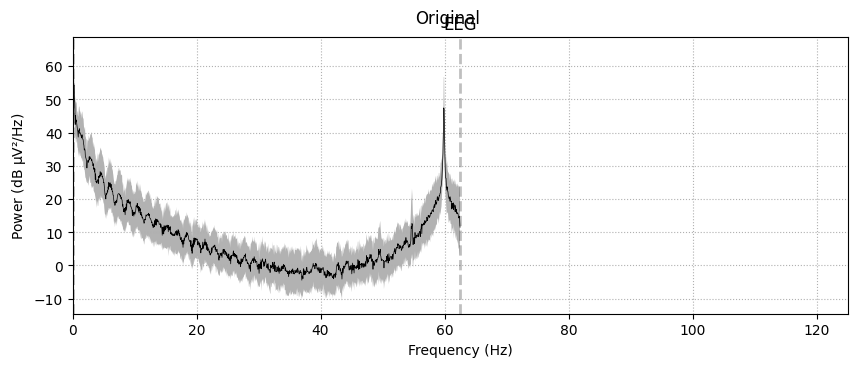

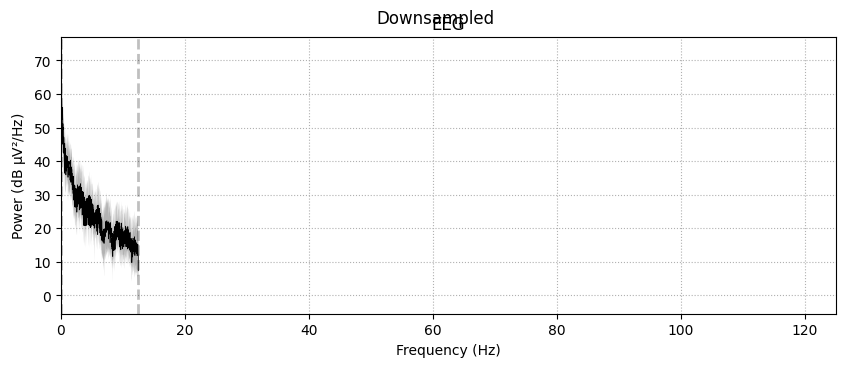

In [12]:
# for explanation only: resampling
ori_sr = raw.info['sfreq']
raw_downsampled = raw.copy().resample(sfreq=ori_sr/5)

for data, title in zip([raw, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="eeg", exclude="bads")
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, ori_sr))

In [13]:
# for explanation only
original_data = raw.copy().pick_types(eeg=True)._data
downsampled_data = raw_downsampled.copy().pick_types(eeg=True)._data

print(original_data.shape)
print(downsampled_data.shape)

(15, 36500)
(15, 7300)


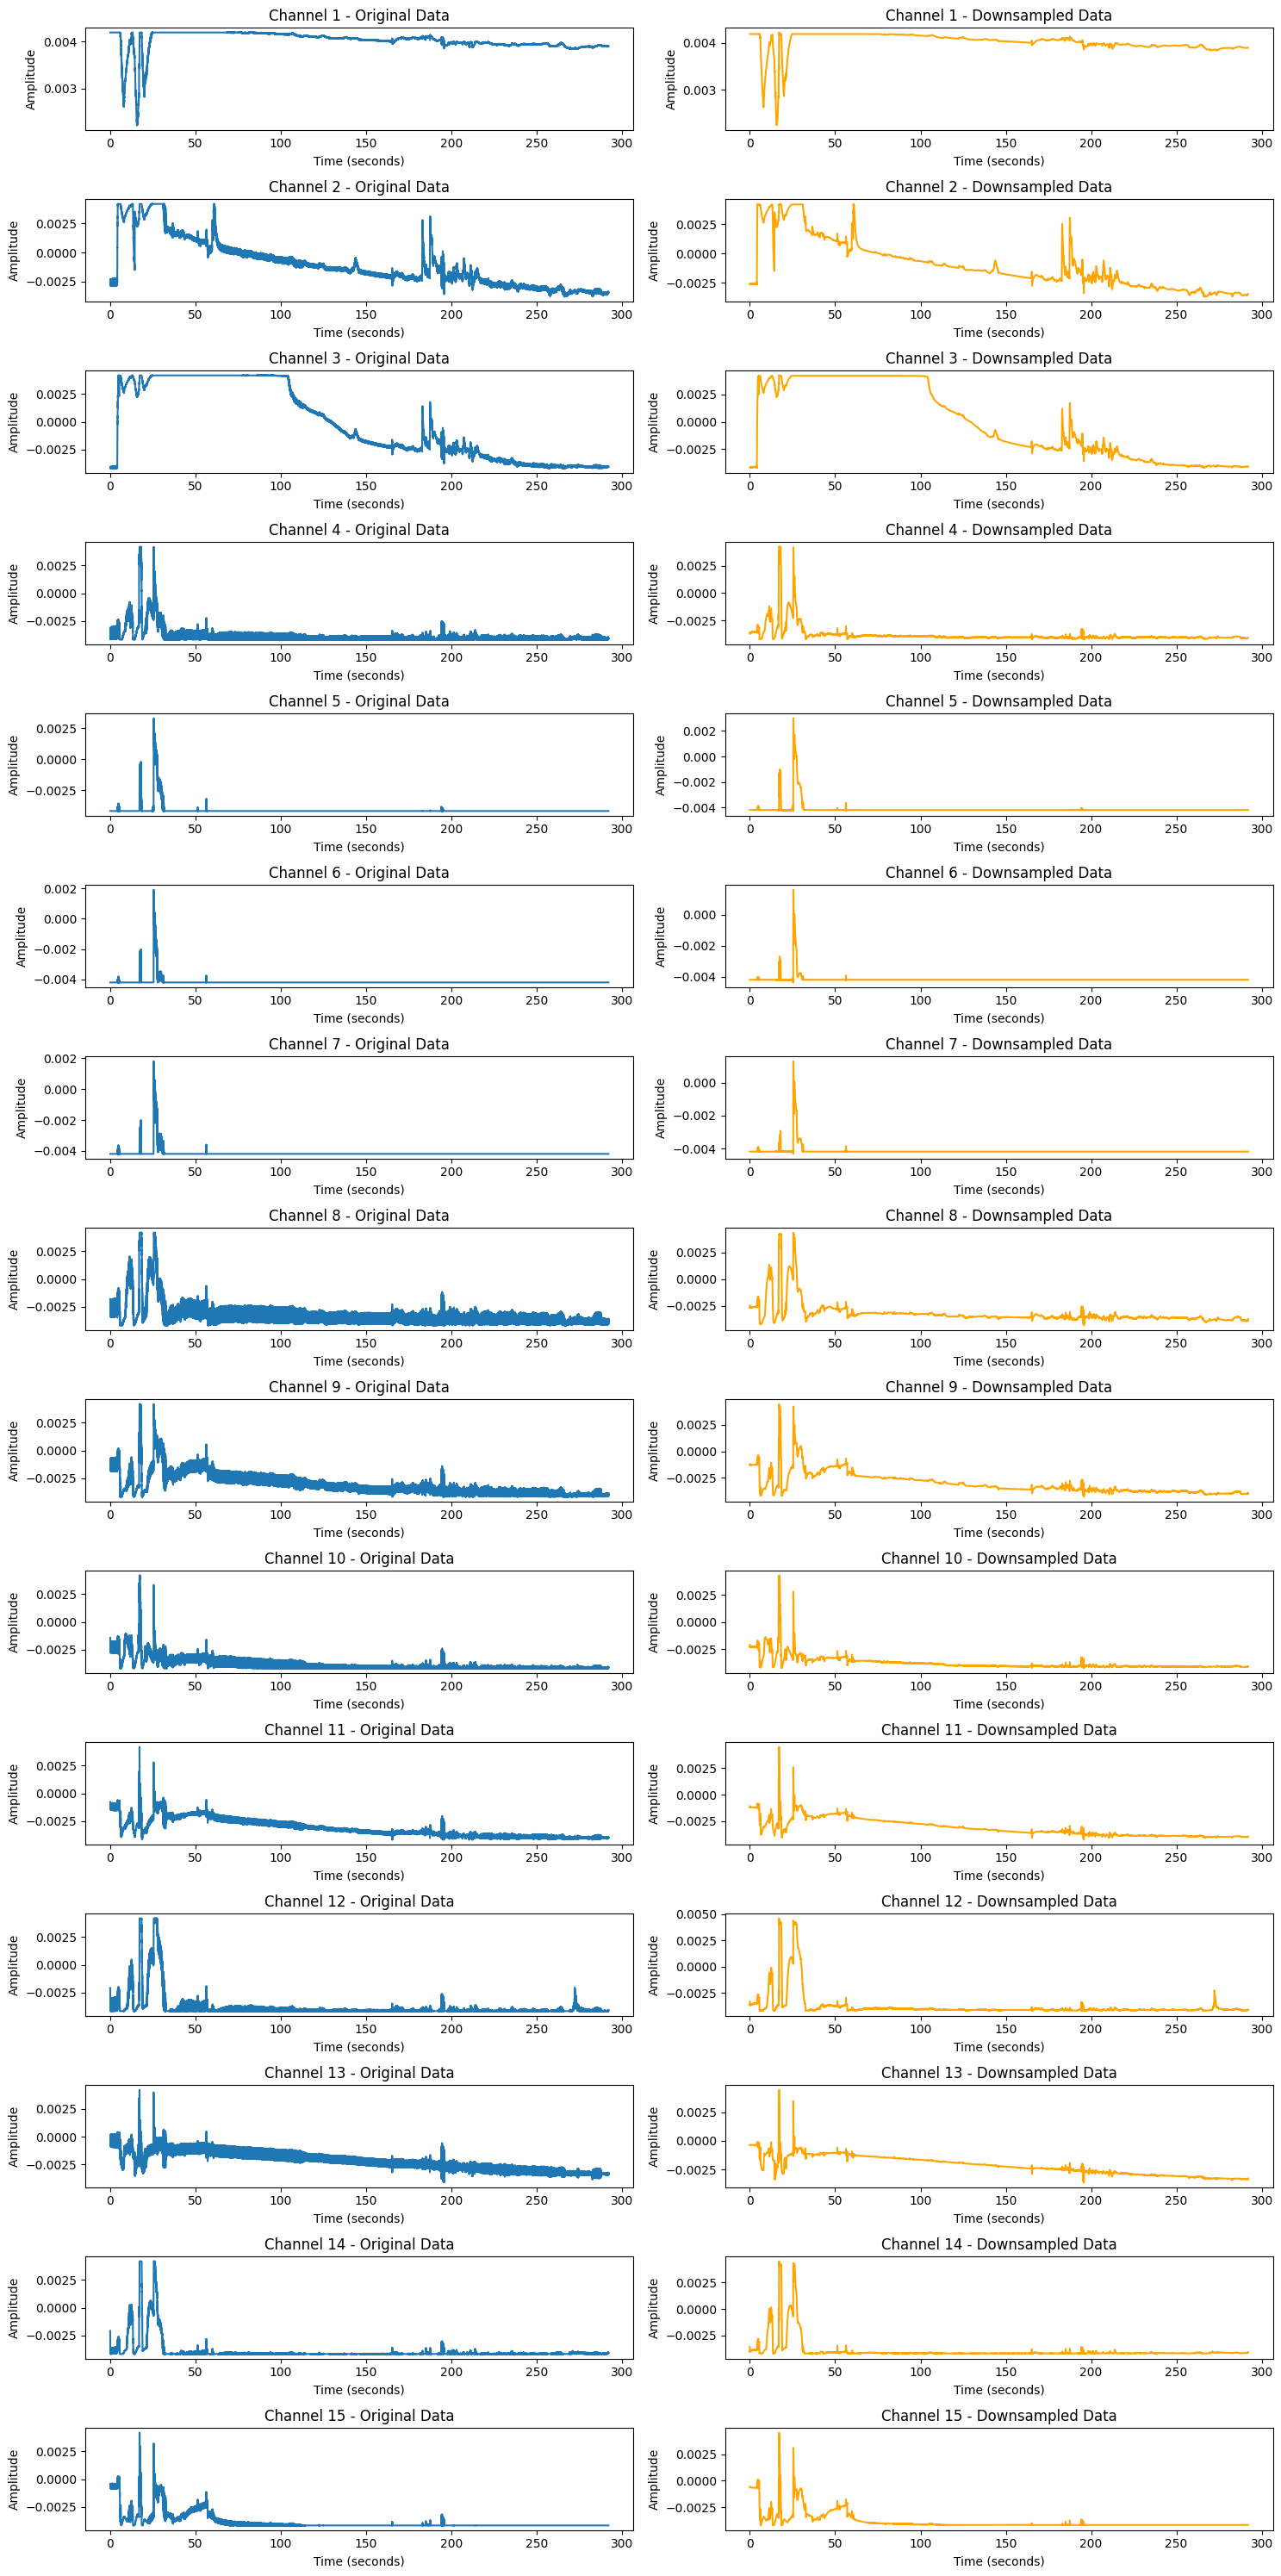

In [14]:
# for explanation only
# ORIGINAL VS DOWNSAMPLED DATA FOR ALL 15 CHANNELS

import numpy as np

# Time vectors for plotting
time_original = np.linspace(0, original_data.shape[1] / raw.info['sfreq'], original_data.shape[1])  # 125 Hz sampling rate
time_downsampled = np.linspace(0, downsampled_data.shape[1] / raw_downsampled.info['sfreq'], downsampled_data.shape[1])  # 25 Hz sampling rate

plt.figure(figsize=(15, 30))  # Adjusting the figure size to accommodate all 15 plots

# Looping through all channels
for channel in range(15):
    # Plot for original data
    plt.subplot(15, 2, 2*channel + 1)  # Determining the position of the subplot
    plt.plot(time_original, original_data[channel], label=f'Channel {channel + 1} Original Data (125 Hz)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Channel {channel + 1} - Original Data')

    # Plot for downsampled data
    plt.subplot(15, 2, 2*channel + 2)  # Determining the position of the next subplot
    plt.plot(time_downsampled, downsampled_data[channel], label=f'Channel {channel + 1} Downsampled Data (25 Hz)', color='orange')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Channel {channel + 1} - Downsampled Data')

plt.tight_layout()
plt.show()

Data cleansing steps:

1. Filtering
2. Referencing
3. Artifact Removal
4. Epoching

/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


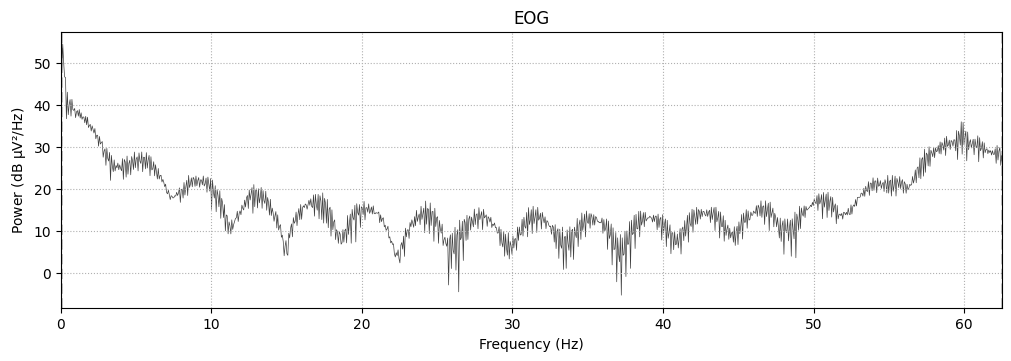

In [15]:
# do EOG need filtering?
# no need, because we can see there's no spike
info_eog = mne.create_info(['hEOG'], raw.info['sfreq'], ch_types='eeg')
raw_eog = mne.io.RawArray(raw['hEOG'][0], info_eog)
raw_eog.plot_psd()
plt.title("EOG");

/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


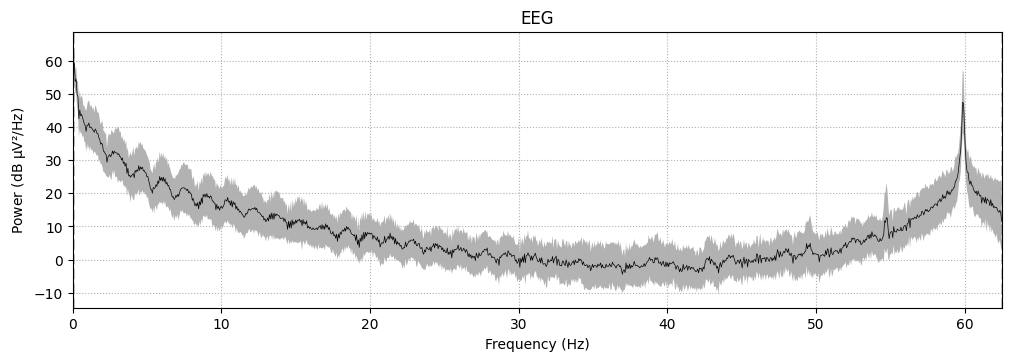

In [16]:
# before cleansing
raw.compute_psd().plot(average=True);
# peak at 60Hz suggest the power-line interference
# the electrical frequency in Taiwan is 60 Hz
# we can think of the electrical power that comes into our home like a heartbeat for our electrical appliances

The following cell codes are to prove:
1. Will the order of filtering affect the signal, i.e., bandpass (BP) followed by notch filtering versus notch filtering followed by bandpass (BP)?

> No, by comparing `raw_bp_notch` with `raw_notch_bp`: the difference is not significant.

2. Do we require a notch filter again if the frequency is outside the bandpass filter range?

> Maybe???, by comparing  `raw_bp_only` with `raw_bp_notch` and `raw_notch_only` with `raw_notch_bp`: the difference is around 7e-8.

> This also proves that by default, filtering in MNE is not applied on the EOG data.

In [17]:
from utils import compare_raw_objects
from itertools import combinations

l_freq = 0.5
h_freq = 45.0
notch_freqs = [60]

raw_bp_notch = raw.copy()
raw_bp_notch.filter(l_freq=l_freq, h_freq=h_freq)
raw_bp_notch.notch_filter(freqs=notch_freqs)

raw_notch_bp = raw.copy()
raw_notch_bp.notch_filter(freqs=notch_freqs)
raw_notch_bp.filter(l_freq=l_freq, h_freq=h_freq)

raw_bp_only = raw.copy()
raw_bp_only.filter(l_freq=l_freq, h_freq=h_freq)

raw_notch_only = raw.copy()
raw_notch_only.notch_filter(freqs=notch_freqs)

raw_variables = {
    "raw_bp_notch": raw_bp_notch,
    "raw_notch_bp": raw_notch_bp,
    "raw_bp_only": raw_bp_only,
    # "raw_notch_only": raw_notch_only
}

for var1, var2 in combinations(raw_variables.keys(), 2):
    raw1 = raw_variables[var1]
    raw2 = raw_variables[var2]

    msg, mad_eeg, mad_eog = compare_raw_objects(raw1, raw2)

    print(f"{var1}\t{var2}\t{msg}\tMAD EEG: {mad_eeg:.20e}\t MAD EOG:{mad_eog:.20e}")

raw_bp_notch	raw_notch_bp	['EEG arrays are nearly equal.', 'EOG arrays are exactly the same.']	MAD EEG: 5.84342105519607253059e-19	 MAD EOG:0.00000000000000000000e+00
raw_bp_notch	raw_bp_only	['EEG arrays are not equal.', 'EOG arrays are exactly the same.']	MAD EEG: 6.94584878297951306712e-08	 MAD EOG:0.00000000000000000000e+00
raw_notch_bp	raw_bp_only	['EEG arrays are not equal.', 'EOG arrays are exactly the same.']	MAD EEG: 6.94584878299110153662e-08	 MAD EOG:0.00000000000000000000e+00


In [18]:
import numpy as np
mad = lambda arr: np.mean(np.abs(arr - np.mean(arr)))
for var in raw_variables.keys():
    arr = raw_variables[var].get_data()
    print(f"{var}\tMAD: {mad(arr):.20e}")

raw_bp_notch	MAD: 5.96748010458752380439e-04
raw_notch_bp	MAD: 5.96748010458752380439e-04
raw_bp_only	MAD: 5.96747996078569463603e-04


### Filtering and Referencing

In [19]:
# FILTERING
# band-pass filter to remove low-frequency drifts and high-frequency noise
raw.filter(l_freq=0.5, h_freq=45.0)
# notch filter to remove power-line interference
raw.notch_filter(freqs=[60])

# REFERENCING
# average reference to reduce common noise sources
raw.set_eeg_reference(ref_channels="average")
raw

<RawEDF | OpenBCI-BDF-2023-09-05_18-30-02.bdf, 19 x 36500 (292.0 s), ~5.3 MB, data loaded>

/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


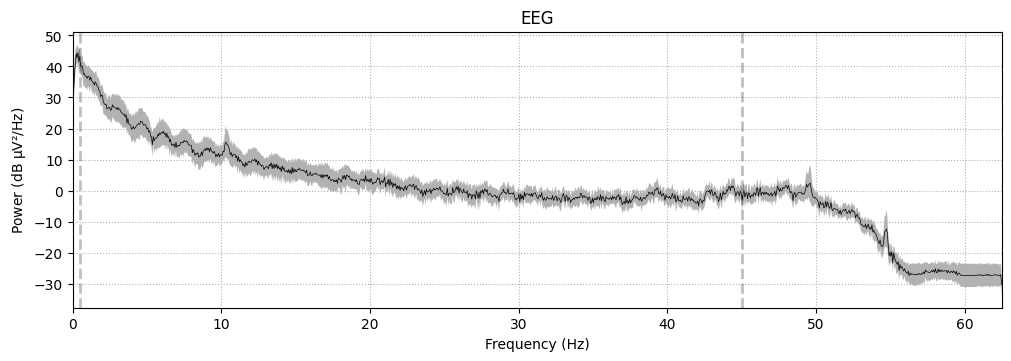

In [20]:
# after filtering
raw.compute_psd().plot(average=True);

### Artifact Removal

In [67]:
# ARTIFACT REMOVAL
# Import necessary libraries
import pywt  # Import the PyWavelets library for wavelet transform

# Define a function for wavelet-based artifact removal
def wavelet_artifact_removal(eeg_data):
    # Define wavelet family and level of decomposition
    wavelet_family = 'db4'  # Choose a wavelet family, e.g., Daubechies 4
    level = 3  # Choose the level of decomposition

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(eeg_data, wavelet_family, level=level)

    # Thresholding to remove artifacts
    threshold = 0.5  # Choose a threshold value empirically
    coeffs_filtered = [pywt.threshold(detail, threshold) for detail in coeffs]

    # Reconstruct the artifact-free EEG signal
    eeg_data_clean = pywt.waverec(coeffs_filtered, wavelet_family)

    return eeg_data_clean

# Apply wavelet-based artifact removal to EEG data
clean_eeg_data = wavelet_artifact_removal(raw.get_data())

# Plot the cleaned EEG data or perform further analysis
# (omitted for brevity)


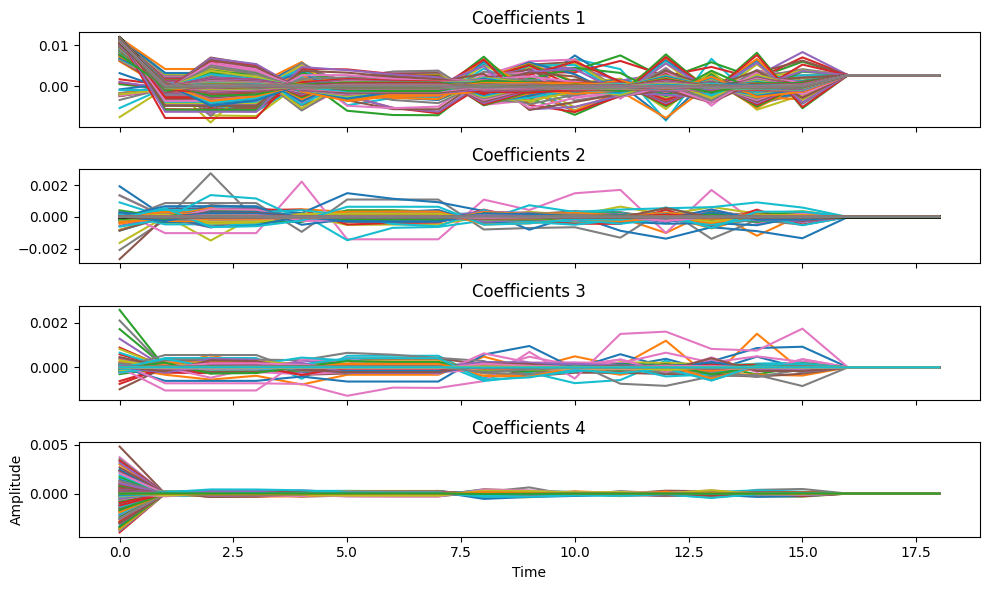

In [70]:
import matplotlib.pyplot as plt

# Function to plot wavelet coefficients
def plot_wavelet_coefficients(coeffs):
    fig, axs = plt.subplots(len(coeffs), 1, figsize=(10, 6), sharex=True)
    for i, coeff in enumerate(coeffs):
        axs[i].plot(coeff)
        axs[i].set_title(f'Coefficients {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Perform wavelet decomposition
coeffs = pywt.wavedec(raw.get_data(), 'db4', level=3)

# Plot wavelet coefficients to visually inspect for artifacts
plot_wavelet_coefficients(coeffs)


In [74]:
pip install EMD-signal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


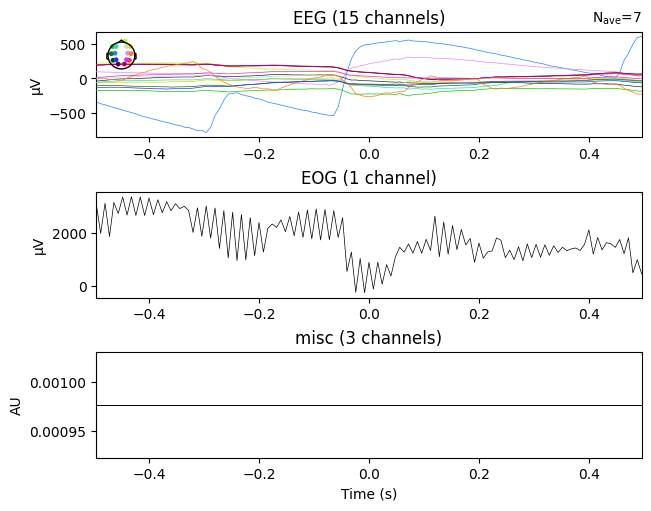

NameError: name 'EOGRegression' is not defined

In [77]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# We need to explicitly specify that we want to average the EOG channel too.
eog_evoked = eog_epochs.average("all")
eog_evoked.plot("all")
fig.set_size_inches(6, 6)

# perform regression on the evoked blink response
model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
fig = model_evoked.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline()
fig = epochs_clean_evoked.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

# for good measure, also show the effect on the blink evoked
eog_evoked_clean = model_evoked.apply(eog_evoked)
eog_evoked_clean.apply_baseline()
eog_evoked_clean.plot("all")
fig.set_size_inches(6, 6)

<ICA | raw data decomposition, method: fastica (fit in 46 iterations on 36500 samples), 14 ICA components (15 PCA components available), channel types: eeg, no sources marked for exclusion>

In [59]:
# ARTIFACT REMOVAL
from sklearn.decomposition import PCA

# Initialize PCA with appropriate number of components
n_components = 19  # tentukan jumlah komponen berdasarkan kebutuhan Anda
pca = PCA(n_components=n_components, random_state=333)

# Transform EEG data using PCA
eeg_data_pca = pca.fit_transform(raw.get_data().T).T

# If you want to visualize the components or inspect them further,
# you can do so using pca.components_ and pca.explained_variance_ratio_

# Now, if you want to proceed with the cleaned EEG data, you can use it further
# For example, if you're using MNE, you can create a Raw object with cleaned data:
cleaned_raw = mne.io.RawArray(eeg_data_pca, raw.info)

# If you have annotations, you might need to copy them to the cleaned raw object:
cleaned_raw.set_annotations(raw.annotations)


<RawArray | 19 x 36500 (292.0 s), ~5.3 MB, data loaded>

In [63]:
# ARTIFACT REMOVAL
from sklearn.decomposition import PCA

# Initialize PCA with appropriate number of components
n_components = 19  # tentukan jumlah komponen berdasarkan kebutuhan Anda
pca = PCA(n_components=n_components, random_state=333)

# Transform EEG data using PCA
eeg_data_pca = pca.fit_transform(raw.get_data().T).T

# If you want to visualize the components or inspect them further,
# you can do so using pca.components_ and pca.explained_variance_ratio_

# Now, if you want to proceed with the cleaned EEG data, you can use it further
# For example, if you're using MNE, you can create a Raw object with cleaned data:
cleaned_raw = mne.io.RawArray(eeg_data_pca, raw.info)

# If you have annotations, you might need to copy them to the cleaned raw object:
cleaned_raw.set_annotations(raw.annotations)
 

pca.components_[18]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.])

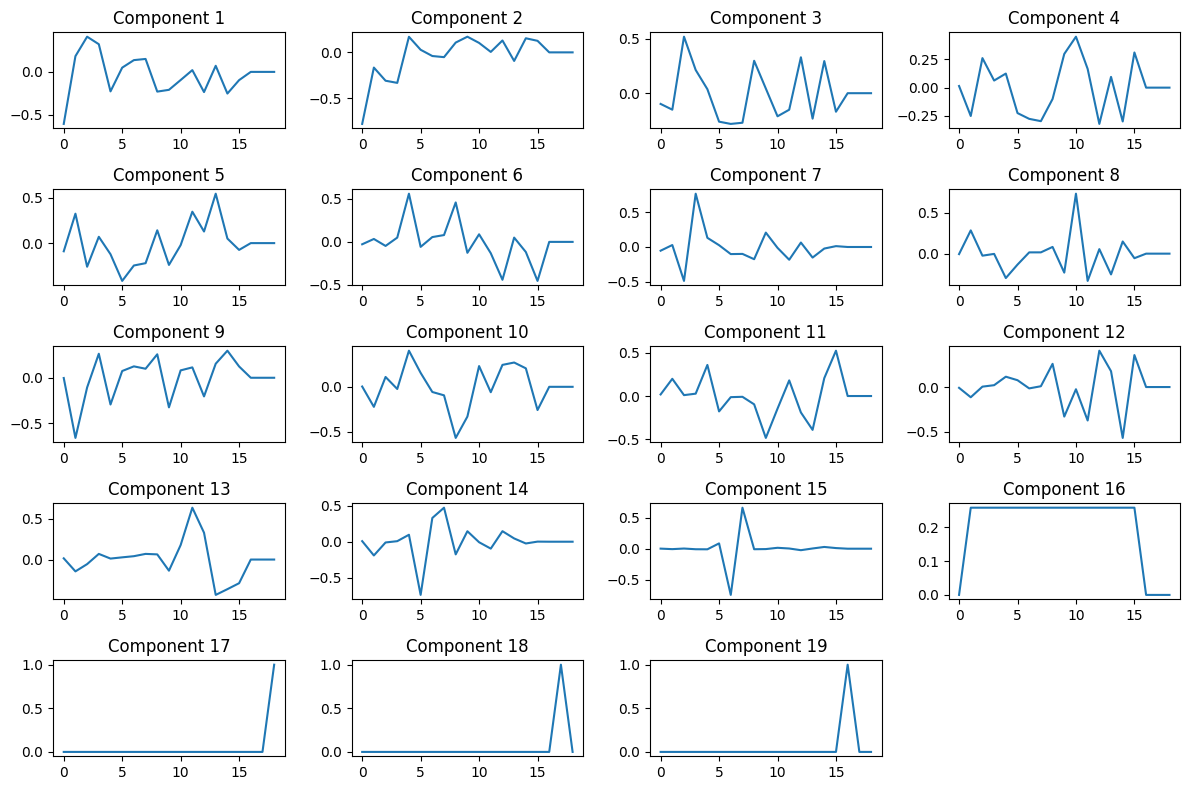

In [64]:
import matplotlib.pyplot as plt

# Plot the components
plt.figure(figsize=(12, 8))
for i in range(n_components):
    plt.subplot(5, 4, i + 1)
    plt.plot(pca.components_[i])
    plt.title(f'Component {i + 1}')
plt.tight_layout()
plt.show()

In [21]:
# ARTIFACT REMOVAL
# Initialize ICA
ica = mne.preprocessing.ICA(n_components=None, random_state=333)

# Fit ICA to EEG data
ica.fit(raw)

<ICA | raw data decomposition, method: fastica (fit in 46 iterations on 36500 samples), 14 ICA components (15 PCA components available), channel types: eeg, no sources marked for exclusion>

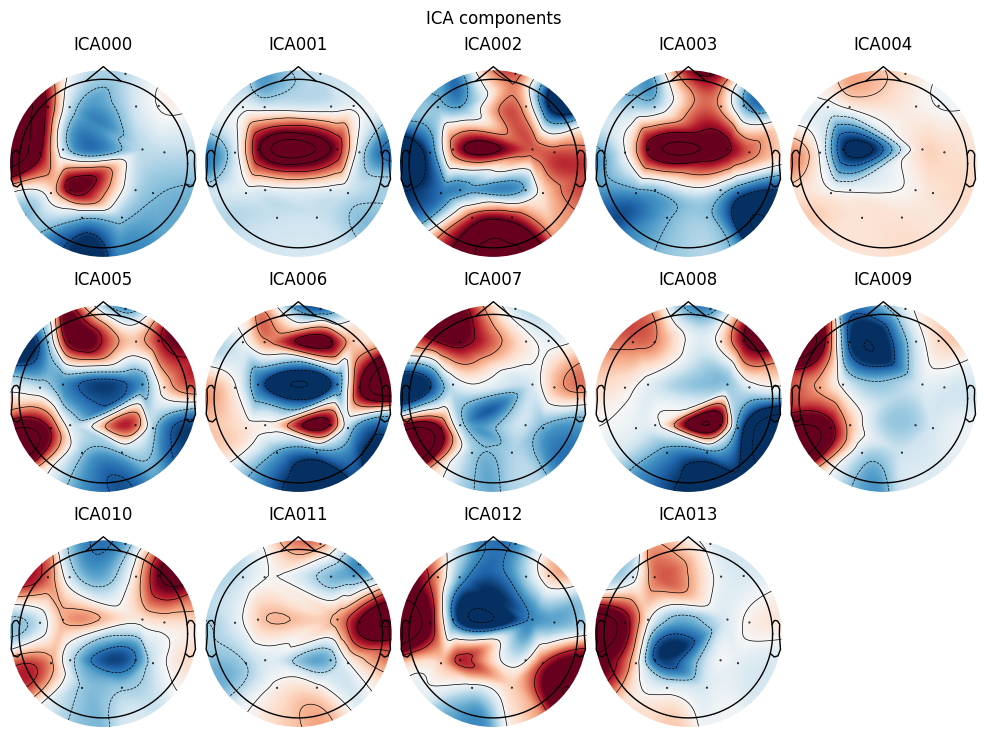

In [22]:
# Plot the components to visually inspect for artifacts
ica.plot_components();

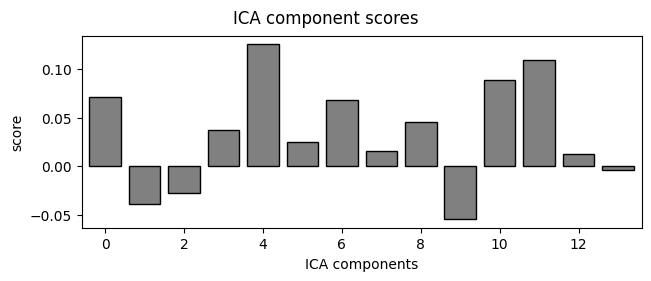

In [23]:
# automatically identify EOG-related components
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='hEOG', threshold='auto')
ica.plot_scores(eog_scores)
if len(eog_indices) > 0:
    plot(eog_indices)
    ica.plot_components(picks=eog_indices)

In [24]:
# Exclude EOG-related components from the EEG data
ica.exclude = eog_indices

# Apply ICA to remove EOG artifacts
raw = ica.apply(raw)
raw

<RawEDF | OpenBCI-BDF-2023-09-05_18-30-02.bdf, 19 x 36500 (292.0 s), ~5.3 MB, data loaded>

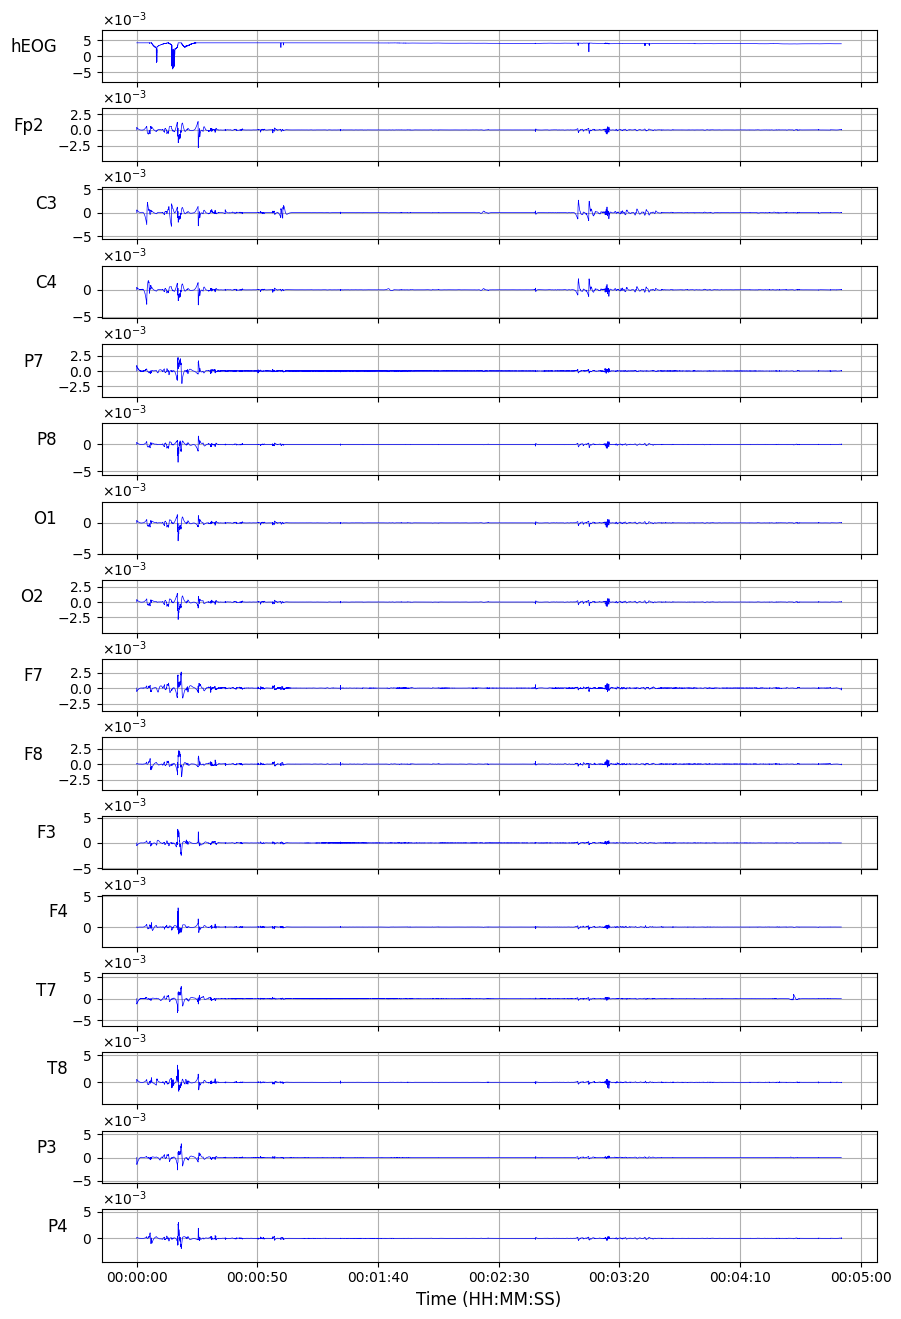

In [25]:
plot_selected_channels(
    data=raw._data,
    channel_names=channels,
    selected_channels=picks,
    sampling_rate=125,
    y_padding_percent=0.5
)

/home/deeplab307-170/miniconda3/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


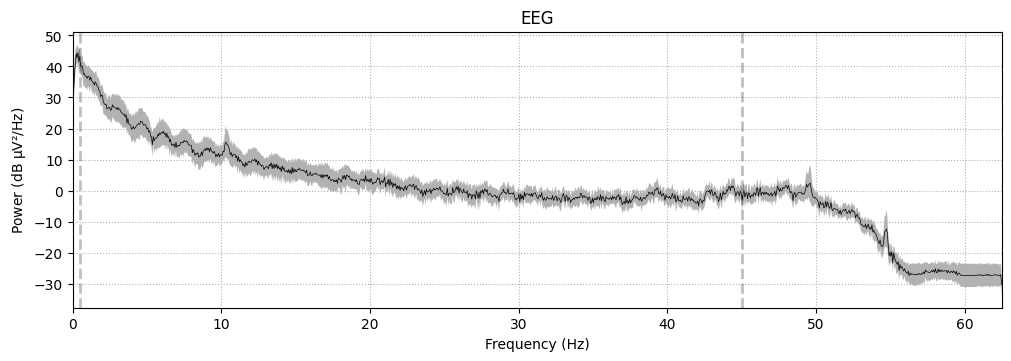

In [26]:
# after artifact removal
raw.compute_psd().plot(average=True);

In [27]:
# pick certain channels only
# raw = raw.pick_types(eeg=True, eog=False, misc=False)
raw._data.shape

(19, 36500)

In [38]:
import os
import numpy as np
import mne
from mne.preprocessing import EOGRegression

# Input data parameters
root_path = 'eeg_data/openbci'
file_name = 'OpenBCI-BDF-2023-09-05_18-30-02.bdf'
channel_renaming_dict = {
    'EEG 1': 'hEOG',
    'EEG 2': 'Fp2',
    'EEG 3': 'C3',
    'EEG 4': 'C4',
    'EEG 5': 'P7',
    'EEG 6': 'P8',
    'EEG 7': 'O1',
    'EEG 8': 'O2',
    'EEG 9': 'F7',
    'EEG 10': 'F8',
    'EEG 11': 'F3',
    'EEG 12': 'F4',
    'EEG 13': 'T7',
    'EEG 14': 'T8',
    'EEG 15': 'P3',
    'EEG 16': 'P4'
}

# Read single bdf file
raw = mne.io.read_raw_bdf(
    input_fname=os.path.join(root_path, file_name),
    eog=['EEG 1'],
    misc=['Accel X', 'Accel Y', 'Accel Z'],
    preload=True,
)

# Change channel name accordingly
raw.rename_channels(channel_renaming_dict)

# Set channel positions
raw.set_montage('standard_1020')

# The regression technique works regardless of chosen reference. However, it is
# important to choose a reference before proceeding with the analysis.
raw.set_eeg_reference("average")

# Removing slow drifts makes for more stable regression coefficients. Make sure
# to apply the same filter to both EEG and EOG channels!
raw.filter(0.3, 40)

# Define events manually
# Example: Create synthetic events (you need to adapt this based on your needs)
n_samples = len(raw.times)
event_duration = int(raw.info['sfreq'])  # 1 second duration for example
event_samples = np.arange(0, n_samples, 10 * event_duration)  # Every 10 seconds
events = np.column_stack((event_samples, np.zeros(len(event_samples), int), np.ones(len(event_samples), int)))

event_id = {'custom_event': 1}  # Customize this based on your actual event definitions

# Make epochs
epochs = mne.Epochs(raw, events, event_id=event_id, preload=True)

# Display summary of the raw data and epochs
print(raw.info)
print(epochs)


<Info | 10 non-empty values
 bads: []
 ch_names: hEOG, Fp2, C3, C4, P7, P8, O1, O2, F7, F8, F3, F4, T7, T8, P3, ...
 chs: 1 EOG, 15 EEG, 3 misc
 custom_ref_applied: True
 dig: 18 items (3 Cardinal, 15 EEG)
 highpass: 0.3 Hz
 lowpass: 40.0 Hz
 meas_date: 2023-09-05 18:30:03 UTC
 nchan: 19
 projs: []
 sfreq: 125.0 Hz
 subject_info: 3 items (dict)
>
<Epochs |  29 events (all good), -0.2 – 0.496 s, baseline -0.2 – 0 s, ~410 kB, data loaded,
 'custom_event': 29>


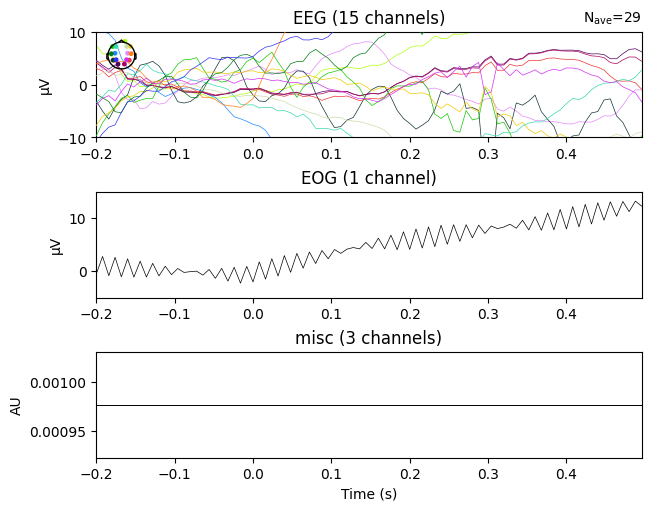

In [40]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-10, 10), eog=(-5, 15)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

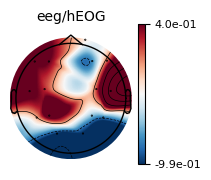

In [41]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)
fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
fig.set_size_inches(3, 2)

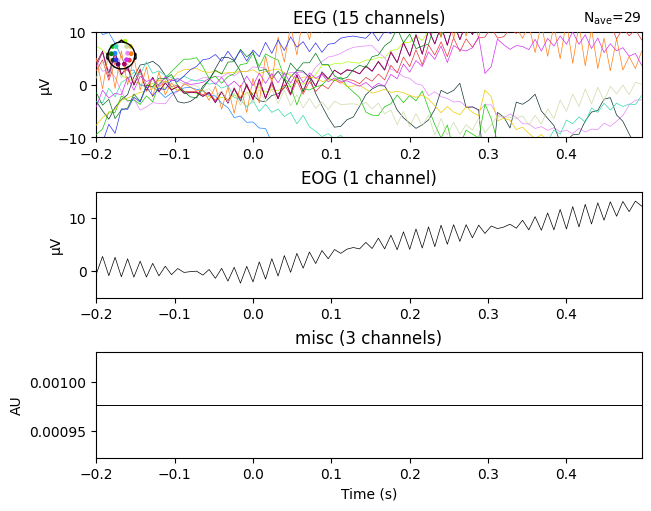

In [42]:
epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

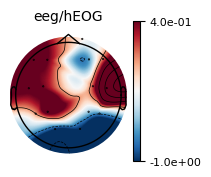

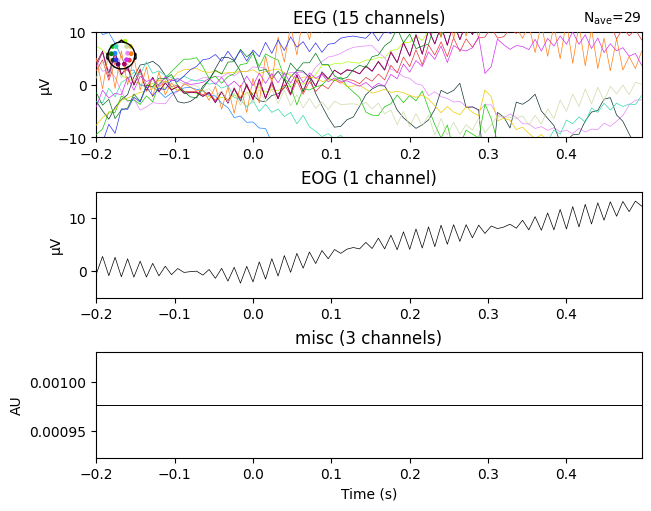

In [43]:
# create epochs with the evoked subtracted out
epochs_sub = epochs.copy().subtract_evoked()

# perform regression
model_sub = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs_sub)
fig = model_sub.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_sub = model_plain.apply(epochs).apply_baseline()
fig = epochs_clean_sub.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

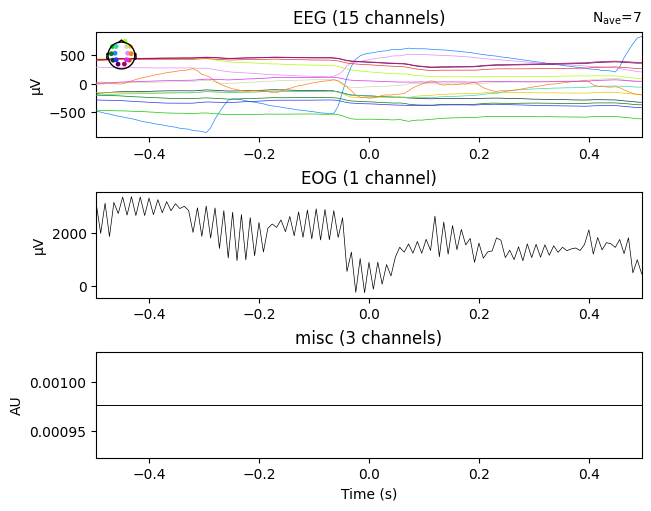

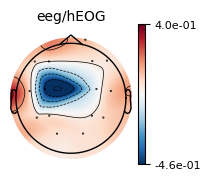

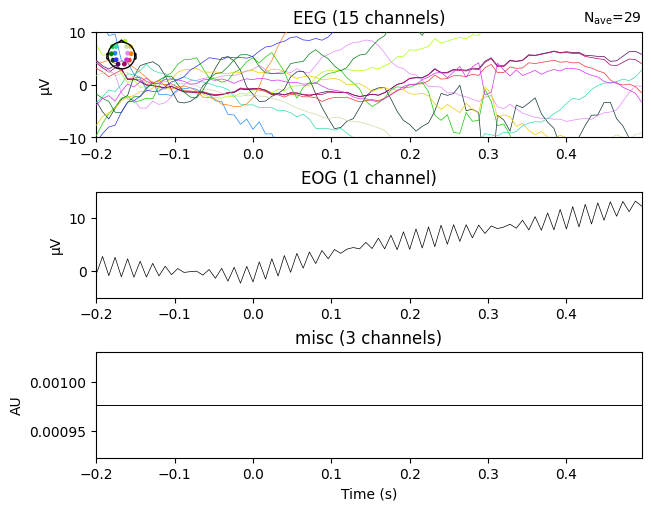

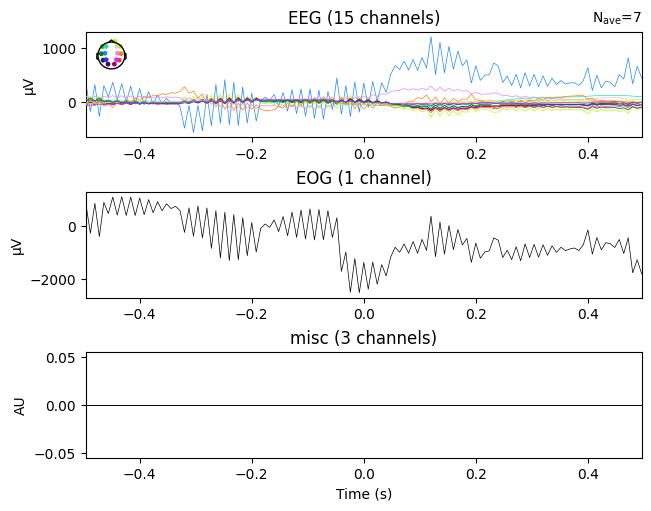

In [44]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# We need to explicitly specify that we want to average the EOG channel too.
eog_evoked = eog_epochs.average("all")
eog_evoked.plot("all")
fig.set_size_inches(6, 6)

# perform regression on the evoked blink response
model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
fig = model_evoked.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline()
fig = epochs_clean_evoked.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

# for good measure, also show the effect on the blink evoked
eog_evoked_clean = model_evoked.apply(eog_evoked)
eog_evoked_clean.apply_baseline()
eog_evoked_clean.plot("all")
fig.set_size_inches(6, 6)

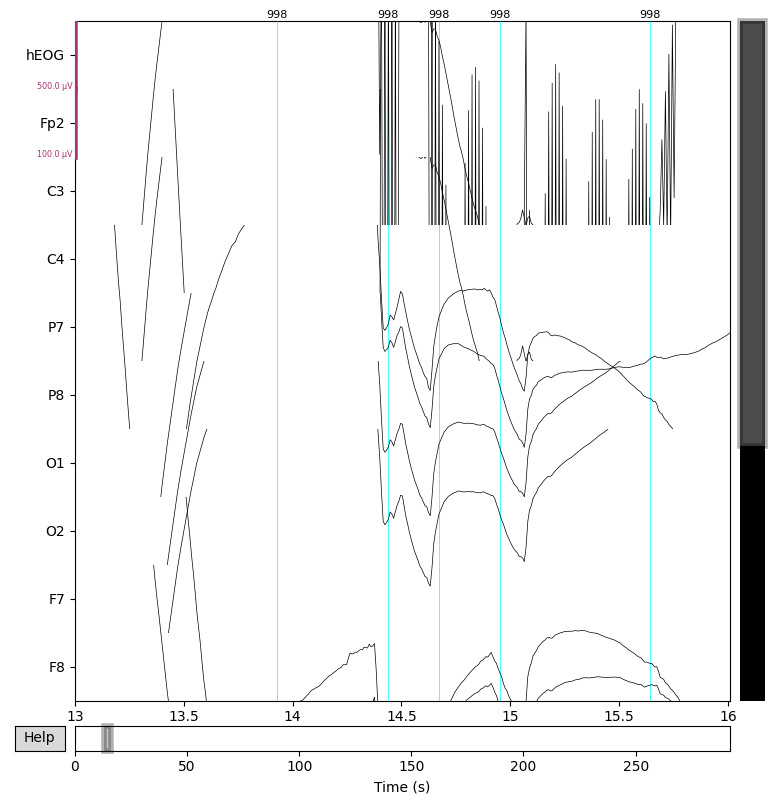

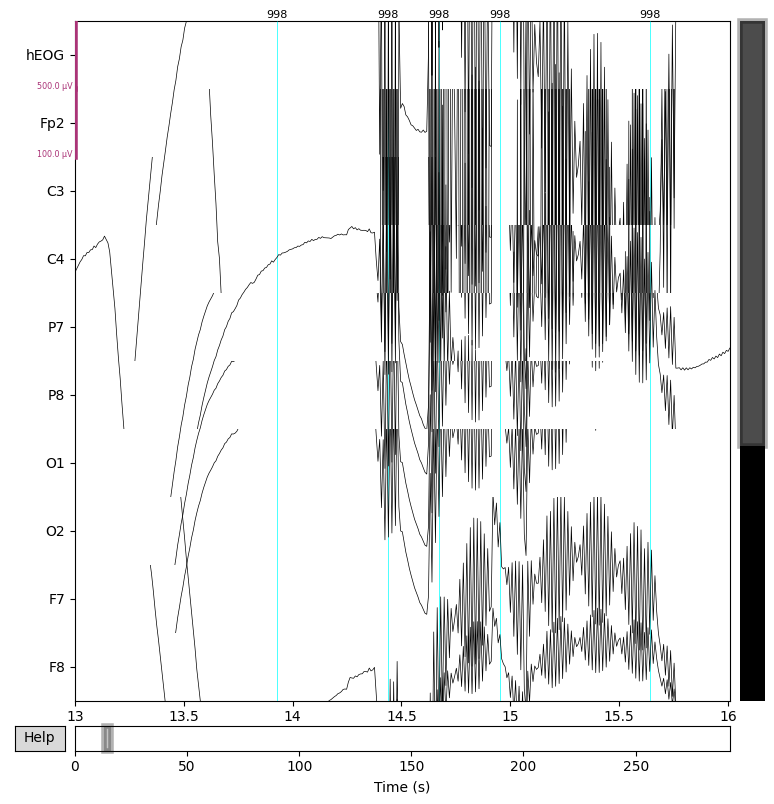

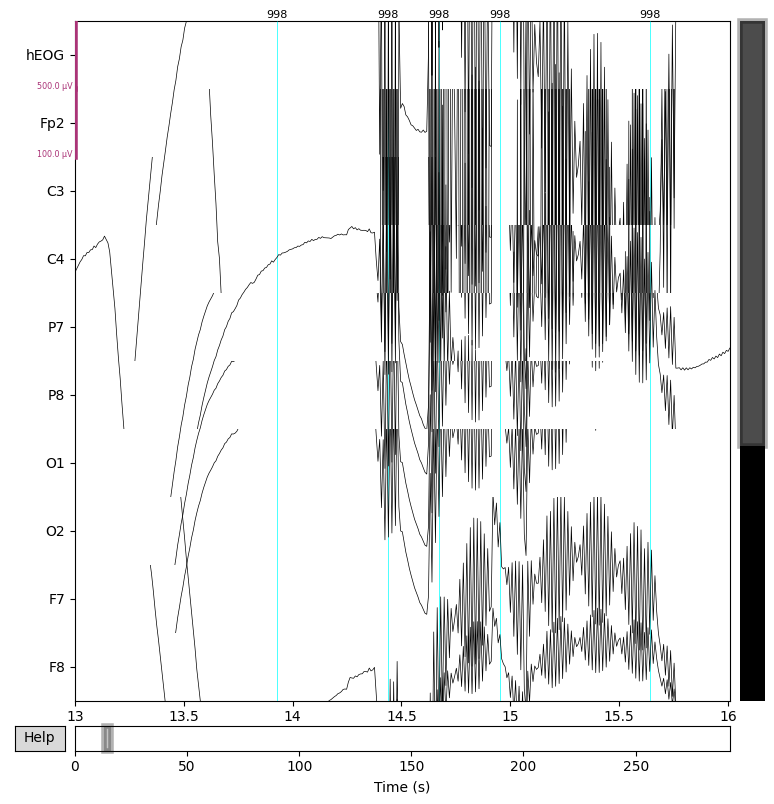

In [45]:
order = np.concatenate(
    [  # plotting order: EOG first, then EEG
        mne.pick_types(raw.info, meg=False, eog=True),
        mne.pick_types(raw.info, meg=False, eeg=True),
    ]
)
raw_kwargs = dict(
    events=eog_epochs.events,
    order=order,
    start=13,
    duration=3,
    n_channels=10,
    scalings=dict(eeg=50e-6, eog=250e-6),
)

# plot original data
raw.plot(**raw_kwargs)

# regress (using coefficients computed previously) and plot
raw_clean = model_evoked.apply(raw)
raw_clean.plot(**raw_kwargs)

### Epoching

```
import numpy as np

# Define a time point for your event
event_time_seconds = 0
event_sample = int(event_time_seconds * raw.info['sfreq'])  # Convert time to sample
event = np.array([[event_sample, 0, 1]])

epochs = mne.Epochs(raw, events=event, event_id=1, tmin=0, tmax=60, baseline=None)
epochs
```

In [41]:
# EPOCHING
total_duration = raw.times[-1] - raw.times[0]
print(total_duration)

sampling_rate = 125
chunk_size = 250
duration = chunk_size / sampling_rate
print(duration)

epochs = mne.make_fixed_length_epochs(raw, duration=duration)
epochs.get_data().shape  # (n_segment, n_channel, chunk_size)

291.992
2.0


(146, 19, 250)

### Visualization

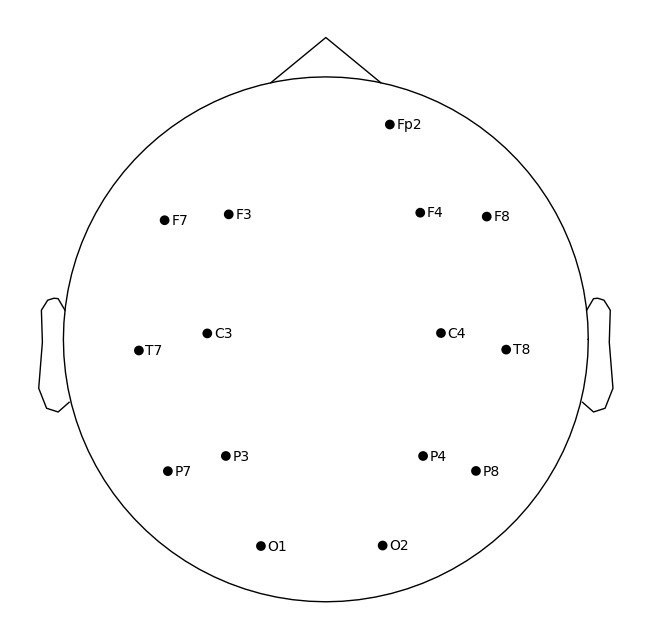

In [42]:
raw.plot_sensors(
    title='Electrode Placement of OpenBCI using 10-20 System',
    sphere=[0, 0.02, 0, 0.1],
    show_names=True
);

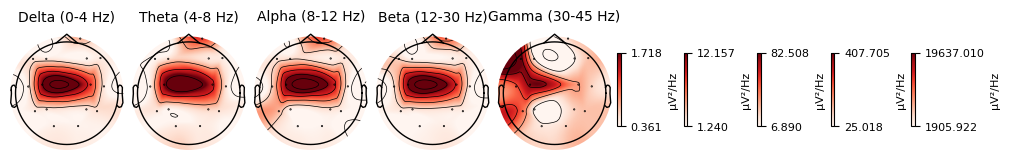

In [43]:
raw.compute_psd().plot_topomap();

### Evoked

Create an Evoked object by averaging the epochs. This step reduces noise and enhances the event-related signal.

In [44]:
evoked = epochs.average()
evoked

<Evoked | '1' (average, N=146), 0 – 1.992 s, baseline off, 15 ch, ~57 kB>

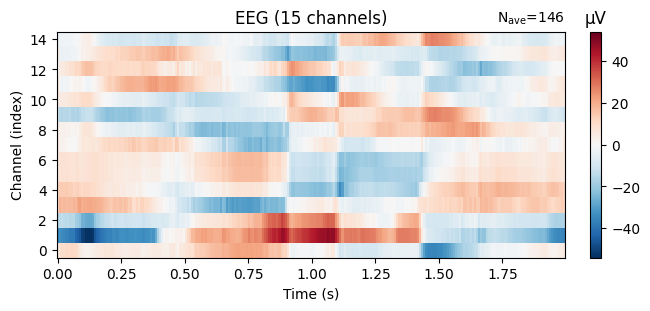

In [45]:
# heatmap time vs channel
evoked.plot_image();

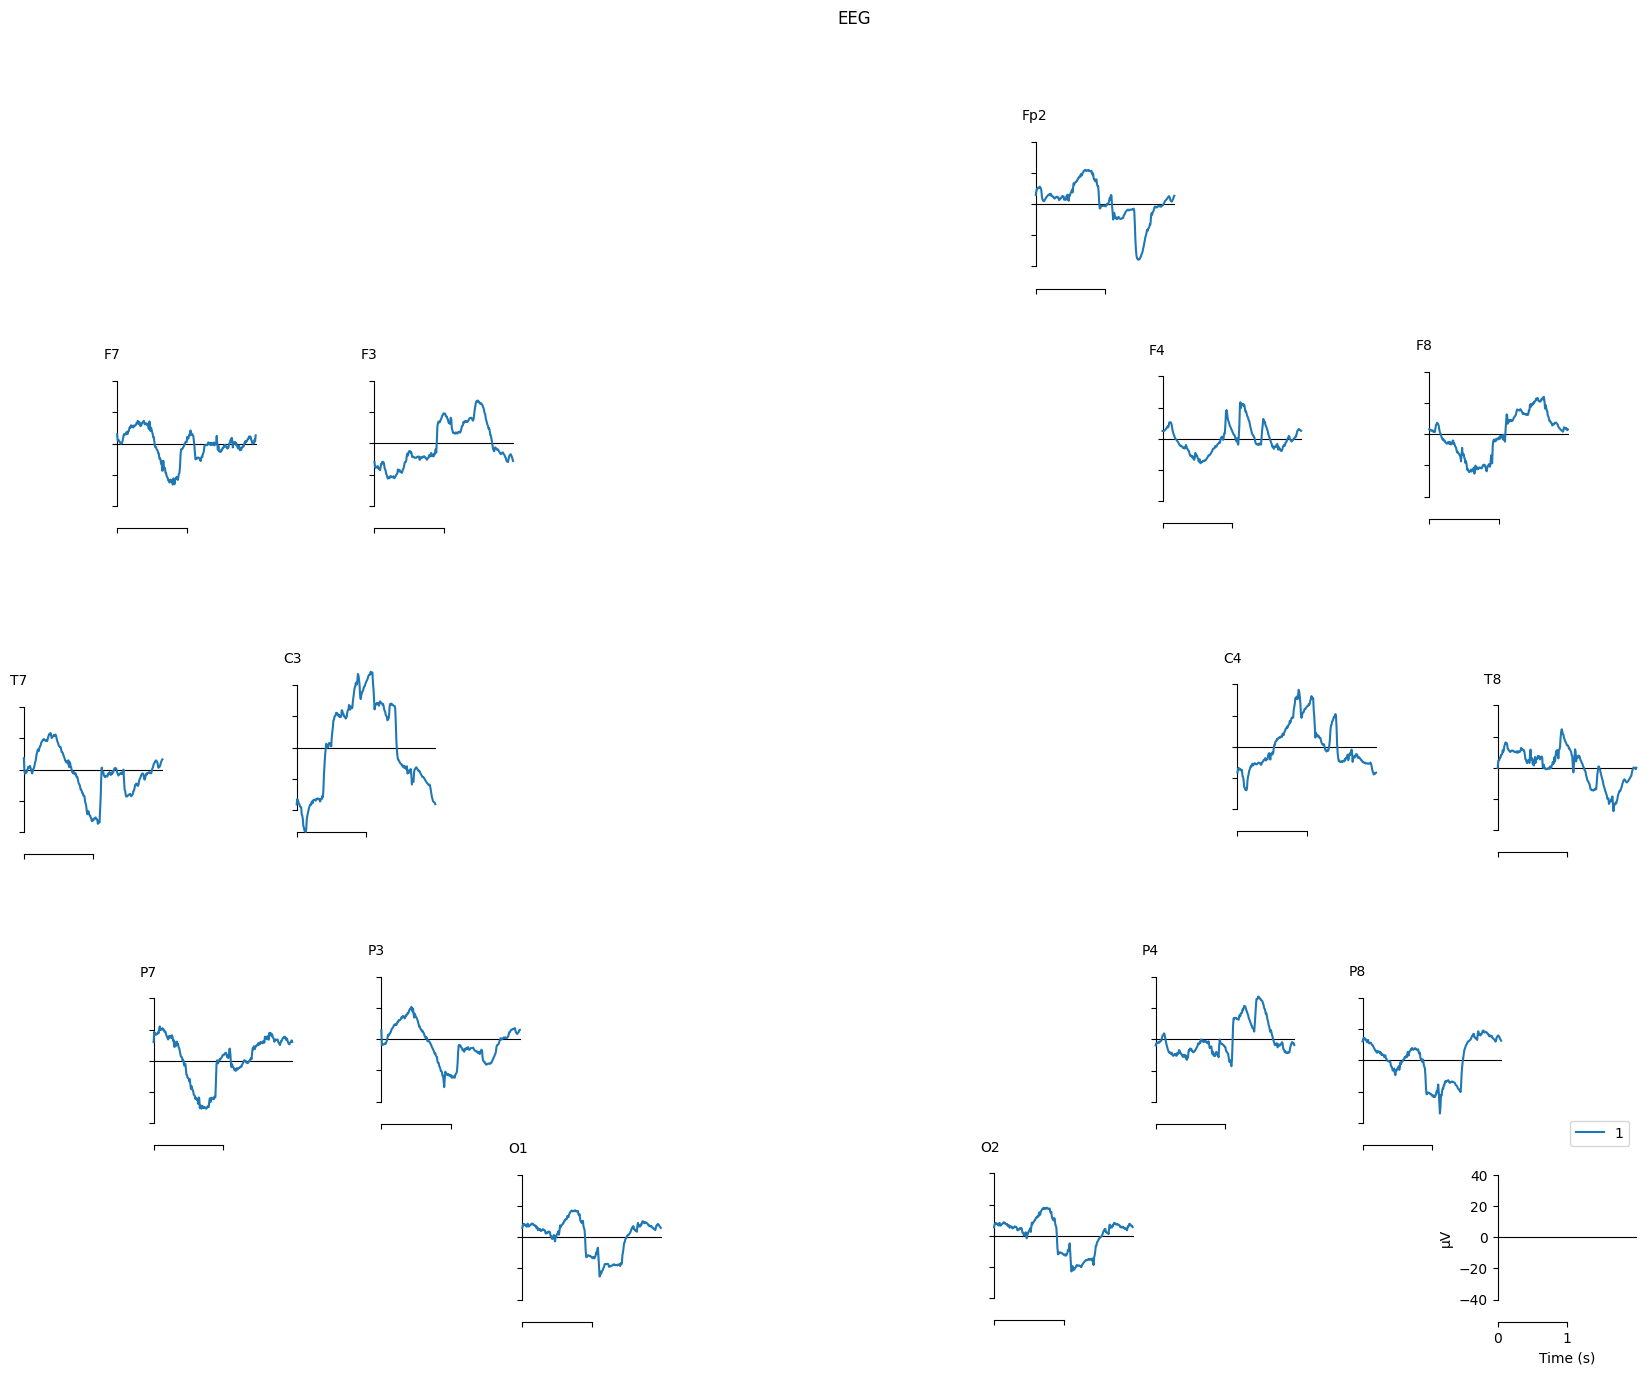

In [46]:
# evoked for each channel
mne.viz.plot_compare_evokeds(evoked, picks="eeg", axes="topo");

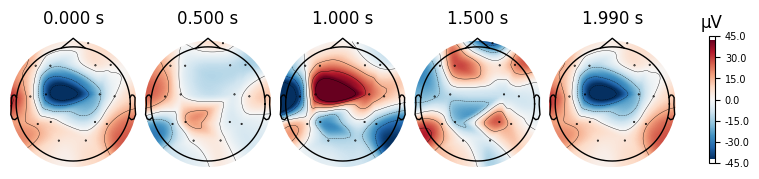

In [47]:
# topomap evoked
times = [0.0, 0.5, 1.0, 1.5, 1.99]
evoked.plot_topomap(ch_type="eeg", times=times, colorbar=True);

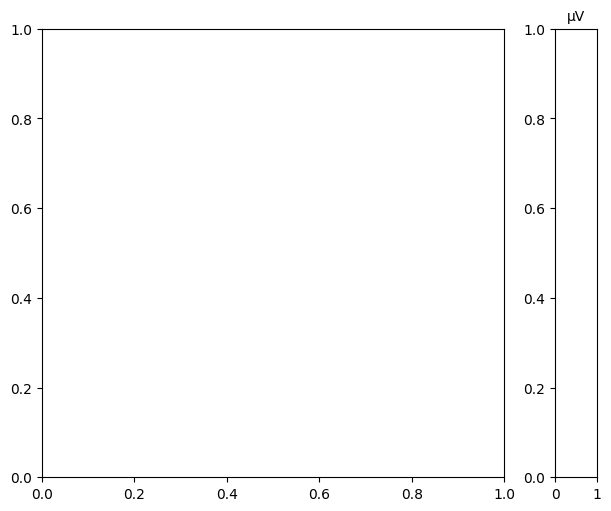

ValueError: unknown file extension: .mp4

In [48]:
%matplotlib inline
times = [0.0, 0.5, 1.0, 1.5, 1.99]
fig, anim = evoked.animate_topomap(ch_type="eeg", times=times, frame_rate=2, blit=False, image_interp='cubic')
anim.save('animation.mp4', writer='ffmpeg')